# Power Calculations
### Jack Bennetto
#### March 12, 2017

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

## Objectives

 * Define power, significance, standard deviation, effect size and sample size, and explain their relationship
 * Compute the sample size needed for an experiment

## Agenda

In the morning we'll talk about power calculations when doing Frequentist A/B testing. In the afternoon we'll move on to Bayesian statistics.

* Review of A/B testing
* Types of Errors and Power
* Calculating sample size

## Morning Lecture: Power Calculations

### A/B Testing

In the last class we talked about Frequentist A/B testing. In this, you set up some test to measure some number of values and decide how surprised you need to be to reject the null hypothesis. This significance level, called $\alpha$, is often something like 0.05, i.e., if there's less than a 5% chance your results (or something even more extreme) could have happened by chance given the null hypothesis, then you assume that hypothesis is wrong.


Of course, you might be wrong and reject the null hypothesis even though it's correct just because of the sample of data you took. That is called a **false positive** or **type I error**. It's positive because you have a positive result (rejecting null) and it's false because it's wrong. I remember that's a type I errors because false positive is much more common than false negative in casual conversation.

The lower you set $\alpha$, the less likely you'll get a type-I error.

But there's a trade-off. The opposite situation is a **false negative** or **type II error**, when the null hypothesis is wrong but you fail to reject it. The probability of a type-II error (assuming the null hypothesis is wrong) is $\beta$.

The lower you set $\alpha$ the higher $\beta$ will be, and vise versa.

**Power**, defined as $1 - \beta$, is the probability that you're correctly able the reject the null hypothesis assuming that it is in fact false.


|               | Reject $H_0$            | Fail to reject $H_0$
|---------------|-------------------------|---------------
|**$H_0$ false**| Correct ($1-\beta$)     | Type II error ($\beta$)
|**$H_0$ true** | Type I error ($\alpha$) | Correct ($1-\alpha$)

#### An aside on terminology

Generally confusion matrices are discussed in the context of predictive statistics, but it's the same concept so I'm including this here to put the various terms in context. Each of the boxes below is a type of success or failure, and each of the terms is the ratio of the total of one box over two other boxes. The rectangles are in the box corresponding to the numerator; the arrows stretch across the boxes of the denominator. So, for example, Sensitivity (a.k.a. TPR, Recall, or Power) is the ratio of the number (or probability) of true positives over true positives plus false negatives.

Here we're interested in Power, $\alpha$, and $\beta$.

![confusion matrix](Confusion Matrix.png)

## Plotting the power

Here's a function to do power calculations and plot them.

In [2]:
def plot_power(n, sigma, effect_size, critical_value):
    standard_error = sigma / n**0.5

    fig, ax = plt.subplots(figsize=(10,6))
    x = np.linspace(-3, 8, 200)
    xpos = x[x >= critical_value]
    xneg = x[x <= critical_value]

    h0 = stats.norm(0, standard_error)
    ha = stats.norm(effect_size, standard_error)

    ax.plot(x, h0.pdf(x), color='red', label='$H_0$')
    ax.plot(x, ha.pdf(x), color='blue', label='$H_A$')
    ax.fill_between(xpos, 0, h0.pdf(xpos), color='red', alpha=0.2, label="$\\alpha$")
    ax.fill_between(xneg, 0, ha.pdf(xneg), color='blue', alpha=0.2, label="$\\beta$")
    ax.fill_between(xpos, 0, ha.pdf(xpos), color='black', hatch='////', alpha=0.2, label="Power")
    ax.axvline(critical_value, color='black', label='critical value')
    ax.set_xlabel("sample mean")
    ax.set_ylabel("pdf")
    ax.set_ylim(ymin=0.0)
    ax.legend()

    print("standard deviation = {0:7.4f}".format(sigma))
    print("sample size (n)    = {0:7d}".format(n))
    print("   standard error  = {0:7.4f}".format(standard_error))
    print("alpha              = {0:7.4f}".format(1-h0.cdf(critical_value)))
    print("effect size        = {0:7.4f}".format(effect_size))
    print("power              = {0:7.4f}".format(1-ha.cdf(critical_value)))
    print("   beta            = {0:7.4f}".format(ha.cdf(critical_value)))

The **effect size** is the amount of difference we hope to detect with our study. If we will only recommend a drug if it will lower blood pressure by at least 10 mm Hg, that's the effect size. In the picture above and calculations below we take the most conservative approach for the effect size. It's possible that effect will be much bigger but that will be *even easier* to detect.

We usually don't know the **standard deviation** $\sigma$ beforehand, and we may need to do a pilot study to estimate this. This part of the calculation involves the most hand waving.

We've already talked about $\alpha$ and **power** (or $1-\beta$). When we create a study, we generally decide what values we need for these for these. It's common to choose 0.05 for $\alpha$ and 0.80 for power, but ultimately we should choose these based on the cost of Type-I and Type-II errors.

The remaining factor is **sample size** n, the number of data in our sample. In general we are trying to calculate this from the other factors.

standard deviation = 10.0000
sample size (n)    =     100
   standard error  =  1.0000
alpha              =  0.0013
effect size        =  3.5000
power              =  0.6915
   beta            =  0.3085


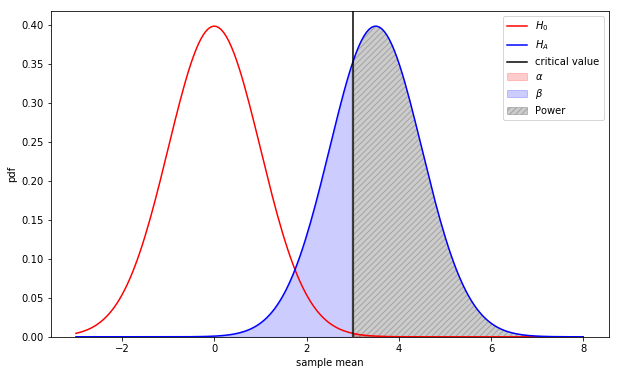

In [3]:
plot_power(n=100, sigma=10.0, effect_size=3.5, critical_value=3)

### Calculating sample size

If the samples are large enough the sample means falls in a normal distribution by the **central limit theorem**. The standard deviation of this distribution is called the **standard error** and is given by

$$SE = \frac{\sigma}{\sqrt{n}}$$

where $\sigma$ is the standard deviation of the original distribution and $n$ is the sample size.

Next we need to calculate the Z-scores corresponding to our chosen $\alpha$ and $\beta$. For this we use the quantile (or percent probability) function, which is the inverse of the cdf.

For the minimum value of $n$, the distance from the $\mu_0$ to the critical value is $SE \cdot Z_\alpha$, and the distance of the critical value to $\mu_A$ is $SE \cdot Z_\beta$. So

$$\begin{align}
\mu_A - \mu_0 & = SE \cdot (Z_\beta + Z_\alpha) \\
              & = \frac{\sigma}{\sqrt{n}} (Z_\beta + Z_\alpha)
\end{align}
$$

so

$$ n \ge \left( \frac{\sigma ( Z_\beta + Z_\alpha )}{\mu_A - \mu_0} \right)^2 $$

In [5]:
def calculate_sample_size(sigma, effect_size, alpha=0.05, power=0.80):
    beta = 1 - power
    return ((sigma*(stats.norm(0,1).ppf(beta) + stats.norm(0,1).ppf(alpha)))/effect_size)**2

In [6]:
calculate_sample_size(10, 2, alpha=0.05, power=0.80)

154.56393080049426

### Relationship of factors

As a summary, here are how the factors relate. This should be read as, for example, "Holding everything else constant, if **Effect size** is **Larger** then **Power** is **Larger**.

| Factor            | Direction |
|-------------------|------|----
| Power             | Larger | Smaller
| Effect size       | Larger | Smaller
| Sample size       | Larger | Smaller
| Standard deviation| Smaller| Larger
| Significance level| Smaller| Larger